# Replication file for 'The Intertemporal Keynesian Cross'
### Alternative ways of solving the IKC (appendix Figure A.1)

Adrien Auclert, Matt Rognlie, Ludwig Straub

April 2024

Import main packages

In [1]:
import numpy as np  
import matplotlib.pyplot as plt 
import json

In [2]:
from sec34_plots import set_texfig
import calibration
import models_heterogeneous, models_analytical
import jacobian_manipulation as jac

# Preliminaries: model and shock
Load the HA-one model and calibration, also calculating $\mathbf{A}$ and $\mathbf{M}$ Jacobians, as in `main_sec5.ipynb`:

In [3]:
with open('solved_params.json', 'r') as f:
    params = json.load(f)

calib_ha_one, _ = calibration.get_ha_calibrations()
ha_one = models_heterogeneous.ha_one
ss = ha_one.steady_state({**calib_ha_one, **params['HA-one']})

In [4]:
T = 300
r = calibration.r
J = ha_one.jacobian(ss, ['Z'], ['C', 'A'], T=T)
M, A = J['C', 'Z'], J['A', 'Z']

Now specify our fiscal shock of interest, which for this example we'll choose to have $\rho_G=0.8$ and $\rho_B=0.5$:

In [5]:
from aux_fiscal import Bplan, Tplan

dG = 0.8**np.arange(T)
dB = Bplan(dG, 0.5)
dT = Tplan(dG, dB, 1+r)

# Alternative solution methods
### Approach 1: calculate multiplier $\mathcal{M}$
This approach directly implements the solution $d\mathbf{Y} = \mathcal{M} (d\mathbf{G} - \mathbf{M}d\mathbf{T})$ from proposition 2, where $\mathcal{M} \equiv (\mathbf{K}(\mathbf{I}-\mathbf{M}))^{-1}\mathbf{K} = \mathbf{A}^{-1}\mathbf{K}$ and $\mathbf{K} \equiv -\sum_{t=1}^\infty (1+r)^{-t}\mathbf{F}^t$. We use it as our primary approach in `main_sec5.ipynb`.

In [6]:
K = jac.Kmat(r, T)
curlyM = np.linalg.solve(A, K)
dY_1 = curlyM @ (dG - M @ dT)

### Approach 2: asset Jacobian
This approach directly solves via the lineared asset-market clearing relation $\mathbf{A}(d\mathbf{Y}-d\mathbf{T}) = d\mathbf{B}$, giving $d\mathbf{Y} = \mathbf{A}^{-1}d\mathbf{B} + d\mathbf{T}$.

In [7]:
dY_2 = np.linalg.solve(A, dB) + dT

As discussed in the appendix, it is easy to demonstrate equivalence here to the first approach. ADD MORE CONTENT HERE. We see that the two are numerically quite close:

In [8]:
np.max(np.abs(dY_1 - dY_2))

6.924718576328814e-10

### Approach 3: naively solving the Intertemporal Keynesian Cross
Alternatively, we can write the intertemporal Keynesian cross $d\mathbf{Y} = d\mathbf{G}-\mathbf{M}d\mathbf{T} + \mathbf{M}d\mathbf{Y}$ and naively try to obtain a solution $d\mathbf{Y} = (\mathbf{I}-\mathbf{M})^{-1}(d\mathbf{G}-\mathbf{M}d\mathbf{T})$, ignoring the fact that the actual infinite-dimensional operator $\mathbf{I}-\mathbf{M}$ is not invertible.

In [9]:
dY_3 = np.linalg.solve(np.eye(T) - M, dG - M @ dT)

This delivers roughly the right solution, but the gap with the previous approaches is around $10^{-3}$ (vs. under $10^{-9}$ between the first two approaches):

In [10]:
np.max(np.abs(dY_1 - dY_3))

0.0009034886651701803

It is only possible to implement this approach in the first place because when truncated, $\mathbf{I}-\mathbf{M}$ is not quite singular; but, since it is *close* to being singular, the error tends to be quite large. We see this below with the smallest singular value being around $10^{-8}$:

In [11]:
np.linalg.svd(np.eye(T) - M)[1][-5:]

array([2.53611897e-02, 1.92337930e-02, 1.45487970e-02, 1.15168014e-02,
       1.24801720e-08])

### Approach 4: rounds of a keynesian cross
Here, we try a very different approach, which is to attempt to iteratively solve the Intertemporal Keynesian Cross by repeatedly applying $d\mathbf{Y}^{(k)} = d\mathbf{G} - \mathbf{M}d\mathbf{T} + \mathbf{M}d\mathbf{Y}^{(k-1)}$, by analogy with the traditional idea of iteratively applying the static Keynesian cross.

In [12]:
dY_pe = dG - M @ dT # partial equilibrium impulse
dYk = np.zeros_like(dY_pe) # initialize dY^0 = 0
save = np.empty((10, len(dY_pe))) # save every 500 impulse responses

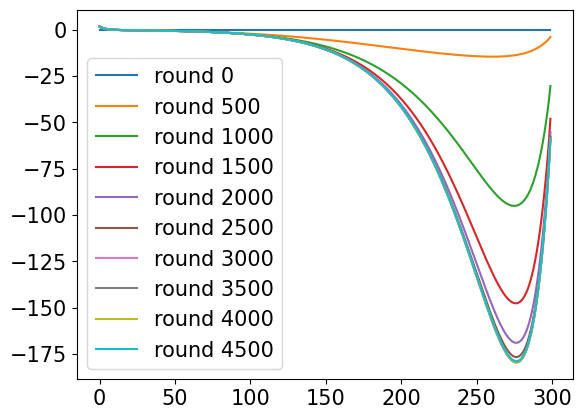

In [13]:
for i in range(10000):
    if i % 500 == 0 and i < 5000:
        plt.plot(dYk, label=f'round {i}')
        save[i // 500,:] = dYk
    dYk = dY_pe + M @ dYk
plt.legend();

We see that this computation converges to some $d\mathbf{Y}^\infty$ that is clearly not a solution. Interestingly, however, it turns out that $d\mathbf{Y}$ differs from $d\mathbf{Y}^\infty$ by a constant multiple $d\lambda$ of the eigenvector $\mathbf{v}$ corresponding to the highest eigenvalue of $\mathbf{M}$.

We identify this $\mathbf{v}$ and calculate $d\lambda$ to enforce that $dY_{T-1} = 0$:

In [14]:
w, v = np.linalg.eig(M)
i = np.argmax(w)
print('Max eigenvalue =', w[i].real)
mvec = v[:,0].real

Max eigenvalue = 0.9999927897315405


In [15]:
dlambda = - dYk[-1] / mvec[-1]
dY_4 = dYk + dlambda * mvec

This process gives us a solution that is close to being correct:

In [16]:
np.max(np.abs(dY_4 - dY_1))

5.554910558203123e-07

Incidentally, sometimes this iterative process converges directly to the correct solution, with no eigenvector correction required. This is the case for our BU or TABU models, as we see below for TABU—although again convergence is slow enough that thousands of iterations are required to get an exact solution:

In [17]:
Ms, As = models_analytical.MA_all(params, r, T)

# true TABU solution
dY_tabu = np.linalg.solve(As['TABU'], dB) + dT

# iterative TABU solution
dY_pe = dG - Ms['TABU'] @ dT # partial equilibrium impulse
dYk = np.zeros_like(dY_pe) # initialize dY^0 = 0

for i in range(10000):
    dYk = dY_pe + Ms['TABU'] @ dYk
    dYk[200:] = 0 # approximately zero after 200 periods, avoids truncation-related issues

np.max(np.abs(dYk - dY_tabu))

8.277308175695814e-11

The key difference between our HA-one model, where the result of iteration needs to be corrected for the eigenvector, and a model like TABU where it does not, is discussed in footnote A-14 in the paper. In general, the operator $\tilde{\mathbf{M}}$ defined by $\tilde{M}_{ts}=(1+r)^{-(t-s)}M_{ts}$ is column-stochastic and can be interpreted as specifying a Markov chain over the natural numbers, giving the odds that a present-value dollar made in period $s$ will be spent in period $t$. 

When this Markov chain is transient, then it has no stationary measure, and the iterative process above converges. When it is recurrent, however, it does have a stationary measure, which corresponds to indeterminacy of the IKC in bounded *present-value* sequences, i.e. there is some $d\mathbf{Y}$ such that $(1+r)^{-t}dY_t$ is bounded and that $\mathbf{M}d\mathbf{Y}=d\mathbf{Y}$. The IKC may be determinate in the current-value sense (i.e. there is still only one solution that is actually bounded), but the iterative process will generally pick up some multiple of the stationary measure $d\mathbf{Y}$ in addition to the unique current-value-bounded solution. This $d\mathbf{Y}$ is distorted due to truncation, but we can still pick it up by looking at which eigenvalue is close to 1.

We can test for transience vs. recurrence by seeing whether applying the asymptotic column of $\tilde{\mathbf{M}}$ (the "symbol") causes on average an increase or decrease in the time period—i.e. whether well-anticipated income is spent, on average, in earlier or later periods than it is received.

In [18]:
m_ha_one = np.concatenate((M[:, -1], M[-1, :-1][::-1]))
m_tabu = np.concatenate((Ms['TABU'][:, -1], Ms['TABU'][-1, :-1][::-1]))
ts = np.arange(2*T-1) - (T-1)   # time indices from -(T-1) through T-1
mtilde_ha_one = m_ha_one * (1+r)**(-ts)
mtilde_tabu = m_tabu * (1+r)**(-ts)

On average, well-anticipated income is spent before it is received in our HA-one model, so that it is recurrent (explaining the difficulty in applying the iteration above):

In [19]:
mtilde_ha_one @ ts

-0.14166782039311068

It is spent after it is received in our TABU model, so that it is transient (explaining why the iteration works without any adjustment):

In [20]:
mtilde_tabu @ ts

0.20856053306760056

### Approach 5: deleting the first row of the IKC
We premultiply by $\mathbf{K}$ when formulating our solution in proposition 2 because this gives us back the asset market clearing condition, which we know to be consistent with equilibrium.

In cases where our model has quasi-Toeplitz form, however, and we can apply the winding number criterion for invertibility, the significant fact about $\mathbf{K}$ is that it has a winding number of -1, so that when we compose it with $\mathbf{I}-\mathbf{M}$, which has a winding number of 1, the resulting $\mathbf{K}(\mathbf{I}-\mathbf{M})$ will have winding number 0 and genericaly be invertible.

In this case, we could replace $\mathbf{K}$ with another operator that has winding number of -1. The simplest choice is arguably $\mathbf{F}$, the forward operator. Premultiplying a sequence-space equation by the forward operator is tantamount to removing the first row of the equation.

Implementing this, we have:

In [21]:
I_M = np.eye(T) - M
dY_pe = dG - M @ dT
dY_5 = np.linalg.solve(I_M[1:, :-1], dY_pe[1:]) # delete first row and last column

This turns out to be extremely accurate, comparable to the first two approaches:

In [22]:
np.max(np.abs(dY_5 - dY_1[:-1]))

9.56037693455869e-10

# Figure A.1

#### Figure A.1

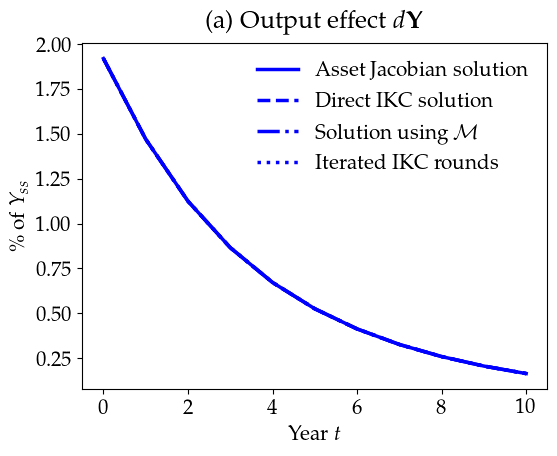

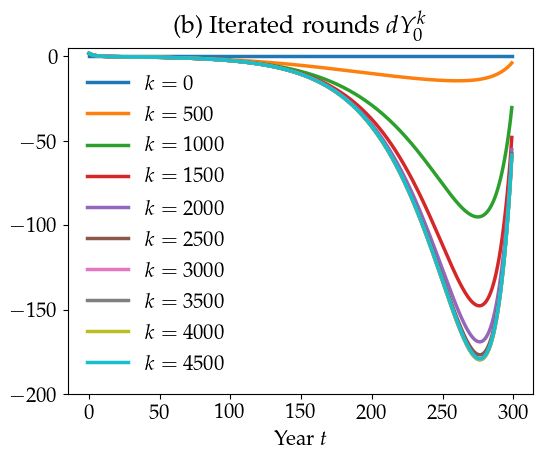

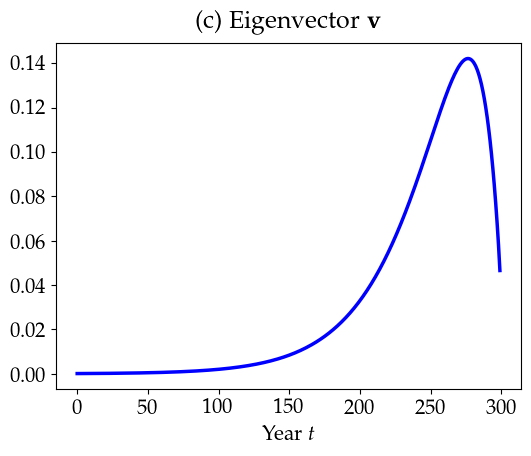

In [23]:
Tplot = 11
style_list = ['solid',  'dashed', 'dashdot', 'dotted']
    
set_texfig(fontsize=15)

plt.figure(figsize =(6, 4.5))
plt.plot(dY_2[0:Tplot][0:Tplot], color='blue', linestyle=style_list[0], label='Asset Jacobian solution', linewidth=2.5)
plt.plot(dY_3[0:Tplot], color='blue', linestyle=style_list[1], label='Direct IKC solution', linewidth=2.5)
plt.plot(dY_1[0:Tplot], color='blue', linestyle=style_list[2], label=r'Solution using $\mathcal{M}$', linewidth=2.5)
plt.plot(dY_4[0:Tplot], color='blue', linestyle=style_list[3], label='Iterated IKC rounds', linewidth=2.5)
plt.xlabel(r'Year $t$')
plt.ylabel(r'\% of $Y_{ss}$')
plt.legend(framealpha=0)
plt.title(r'(a) Output effect $d\mathbf{Y}$', x=0.5, y=1.02)
plt.savefig('figures/figA1_a.pdf', format='pdf', transparent=True, bbox_inches = "tight")
plt.show()

plt.figure(figsize =(6, 4.5))
for k in range(10):
    plt.plot(save[k,:], label=r'$k='+str(500*k)+'$', linewidth=2.5)
plt.xlabel(r'Year $t$')
plt.legend(framealpha=0, loc='lower left')
plt.ylim(-200,5)
plt.title(r'(b) Iterated rounds $dY_0^{k}$', x=0.5, y=1.02)
plt.savefig('figures/figA1_b.pdf', format='pdf', transparent=True, bbox_inches = "tight")
plt.show()

plt.figure(figsize =(6, 4.5))
plt.plot(mvec, color='blue', linewidth=2.5, label=r'$\mathbf{v}$')
plt.xlabel(r'Year $t$')
plt.title(r'(c) Eigenvector $\mathbf{v}$', x=0.5, y=1.02)
plt.savefig('figures/figA1_c.pdf', format='pdf', transparent=True, bbox_inches = "tight")
plt.show()
